In [499]:
import json
d = json.load(open('../ui/data/huawei_france.json', 'r'))['results']
len(d) # 928
MAXIMUM_NB_INST_PER_DOC = 25
d1 = []
for e in d:
    inst = []
    for a in e.get('authorships', []):
        for i in a.get('institutions', []):
            inst.append(i['display_name'].lower().strip())
    inst = list(set(inst))
    if len(inst) > MAXIMUM_NB_INST_PER_DOC:
        print(f"filter out {e['id']} : {len(inst)} institutions")
        continue
    d1.append(e)
len(d1) # 926

inst = {}
for e in d1:
    doc_id = e['id']
    for a in e.get('authorships', []):
        
        current_institutions = a['institutions']
        if a['raw_affiliation_string']:
            assert(len(current_institutions)>0)
        for i in a.get('institutions', []):
            inst_id = i['display_name'].strip().lower()
            #inst_id = i['id']
            if inst_id not in inst:
                inst[inst_id] = {'inst_id': inst_id, 'publications': [], 'links':{}, 'to_keep': False}
            if doc_id not in inst[inst_id]['publications']:
                inst[inst_id]['publications'].append(doc_id)
            for a2 in e.get('authorships', []):
                for j in a2.get('institutions', []):
                    j_inst_id = j['display_name'].strip().lower()
                    if j_inst_id not in inst[inst_id]['links']:
                        inst[inst_id]['links'][j_inst_id] = 0
                    inst[inst_id]['links'][j_inst_id] += 1
                    

len(inst) # 842

sizes = []
inst_to_keep = []
inst_id_to_id = {}
for inst_id in inst:
    if len(inst[inst_id]['publications'])>=10:
        inst[inst_id]['id'] = len(inst_to_keep)
        inst_to_keep.append(inst_id)
        inst[inst_id]['to_keep'] = True
        inst_id_to_id[inst_id] = inst[inst_id]['id']
        sizes.append(len(inst[inst_id]['publications']))
len(inst_to_keep)

filter out https://openalex.org/W2613464217 : 37 institutions
filter out https://openalex.org/W4298208986 : 42 institutions


29

In [500]:
inst['university of marne-la-vallée']

{'inst_id': 'university of marne-la-vallée',
 'publications': ['https://openalex.org/W2952027799',
  'https://openalex.org/W2883911663',
  'https://openalex.org/W4301773521',
  'https://openalex.org/W4300454653',
  'https://openalex.org/W4301224879'],
 'links': {'huawei technologies': 5, 'university of marne-la-vallée': 5},
 'to_keep': False}

In [501]:
matrix_data = []
for i in range(0, len(inst_to_keep)):
    matrix_data.append([0]*len(inst_to_keep))
    
for inst_id in inst:
    if inst[inst_id]['to_keep']:
        ix = inst[inst_id]['id']
        node_size = inst[inst_id]['links'][inst_id]
        for j_inst_id in inst[inst_id]['links']:
            if j_inst_id in inst_id_to_id:
                jx = inst_id_to_id[j_inst_id]
                if ix == jx:
                    matrix_data[ix][jx] = inst[inst_id]['links'][j_inst_id] * 0
                else:
                    matrix_data[ix][jx] = inst[inst_id]['links'][j_inst_id] * 1

In [502]:
from sklearn.manifold import TSNE, Isomap, MDS, LocallyLinearEmbedding, SpectralEmbedding, smacof
import numpy as np
from sklearn.preprocessing import StandardScaler

In [503]:
scaler = StandardScaler(with_std=False)
matrix_data_norm = scaler.fit_transform(matrix_data)

In [504]:
def make_graph(result):
    import matplotlib.pyplot as plt
    import seaborn as sns
    result_df = pd.DataFrame({'x': result[:,0], 'y': result[:,1]})
    fig, ax = plt.subplots(1, figsize=(20, 20))
    sns.scatterplot(x='x', y='y', data=result_df, ax=ax,s=[s*10 for s in sizes])
    #lim = (tsne_result.min()-5, tsne_result.max()+5)
    #ax.set_xlim(lim)
    #ax.set_ylim(lim)
    #ax.set_aspect('equal')

    for ix, row in result_df.iterrows():
        if sizes[ix] < 5:
            continue
        label = inst_to_keep[ix]
        x = row.x
        y = row.y
        ax.text(x, y, label)

    #ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


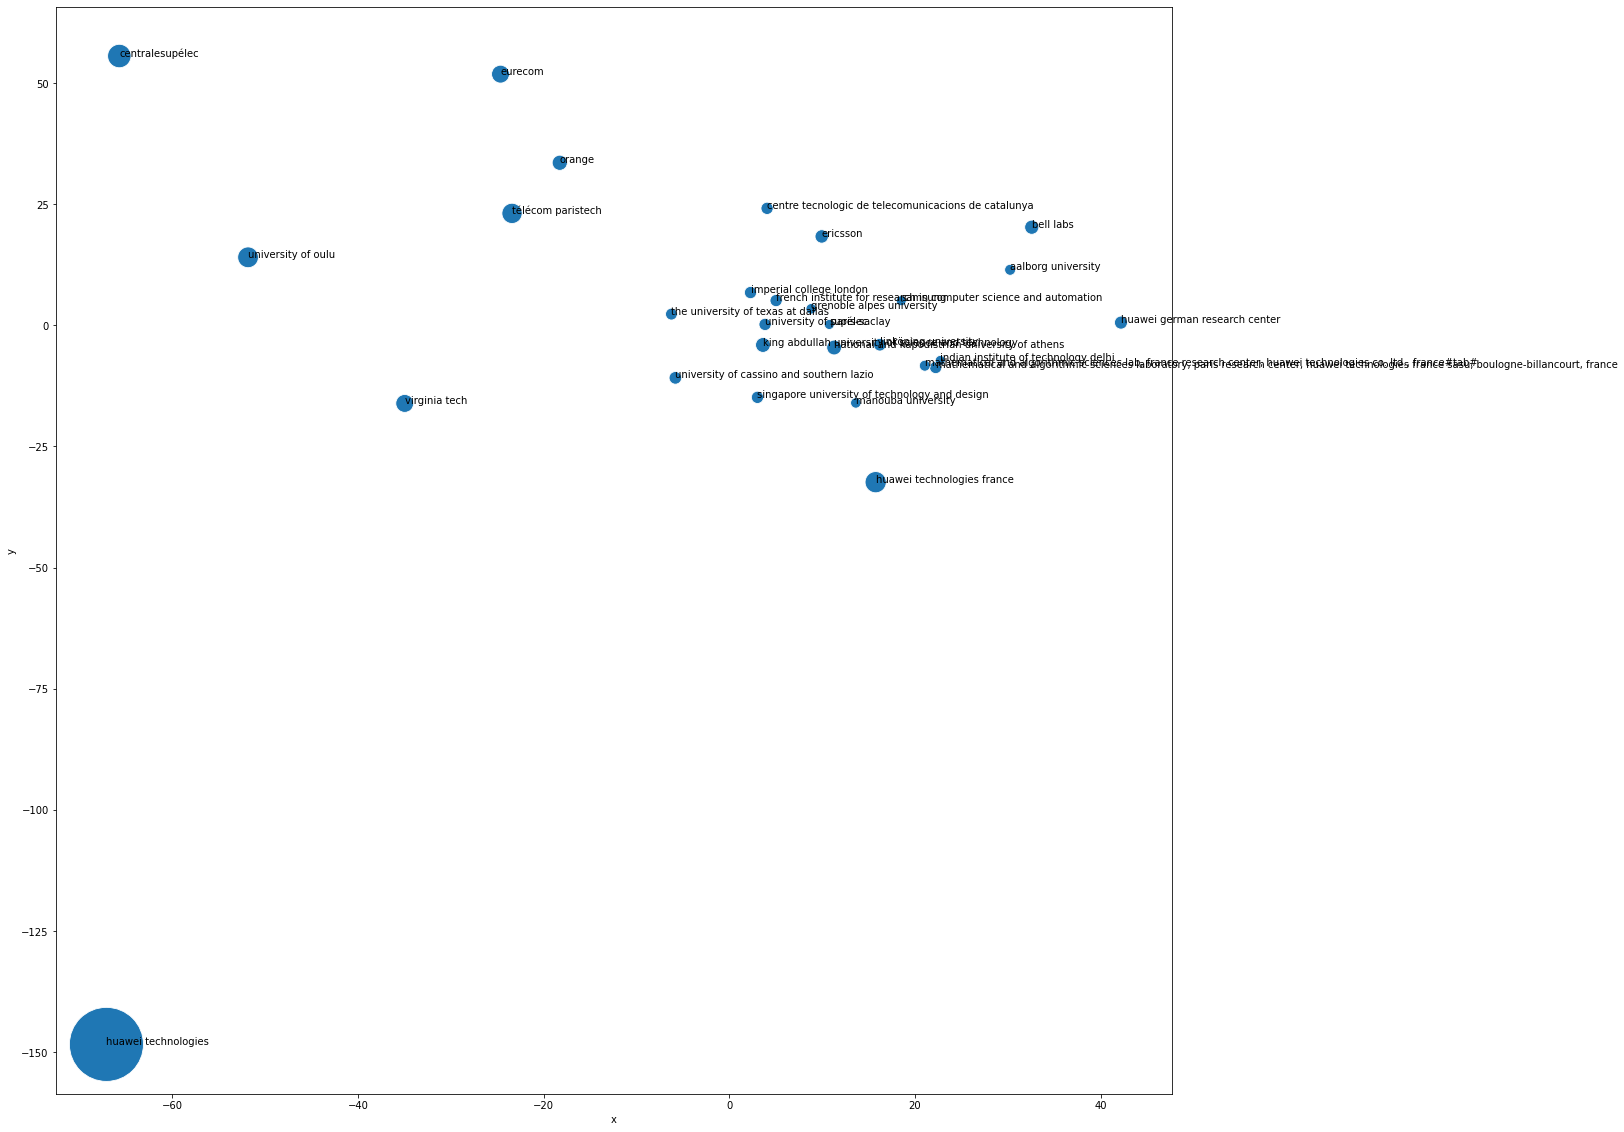

In [505]:
mds = MDS(n_components=2)
make_graph(mds.fit_transform(matrix_data_norm))

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 28 nearest neighbors...
[t-SNE] Indexed 29 samples in 0.000s...
[t-SNE] Computed neighbors for 29 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 29 / 29
[t-SNE] Mean sigma: 12.787155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.242271
[t-SNE] KL divergence after 2650 iterations: 0.213726


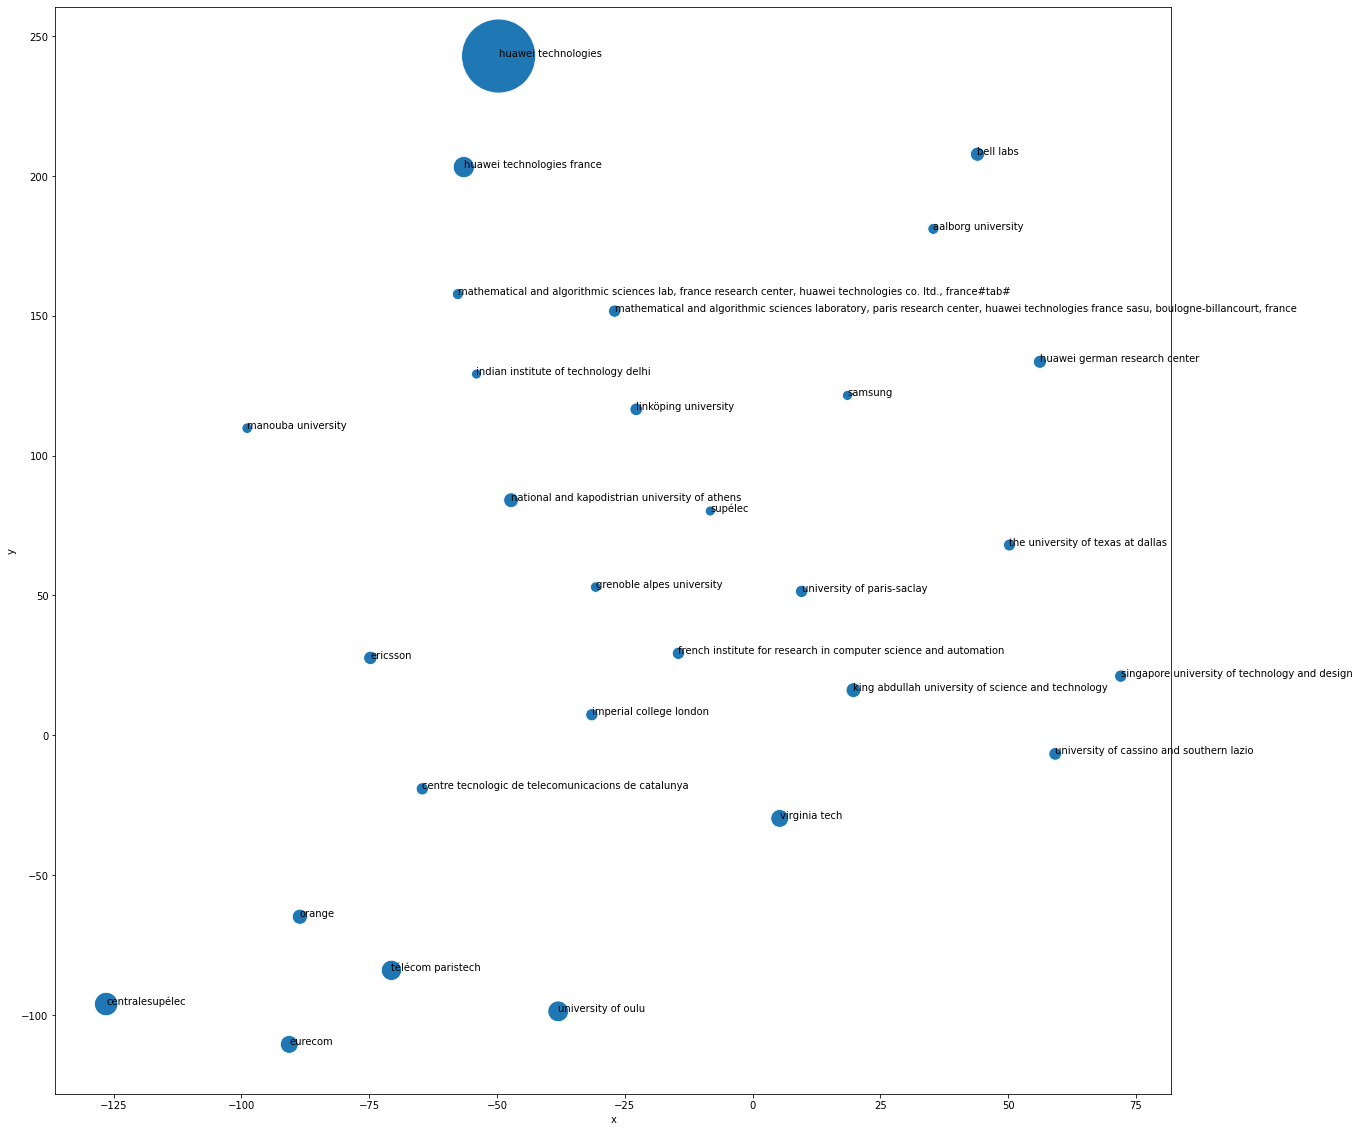

In [506]:
n_components = 2
tsne = TSNE(n_components = n_components, random_state=10, perplexity=10, verbose=1, n_iter=10000, n_iter_without_progress=1000)
make_graph(tsne.fit_transform(matrix_data_norm))

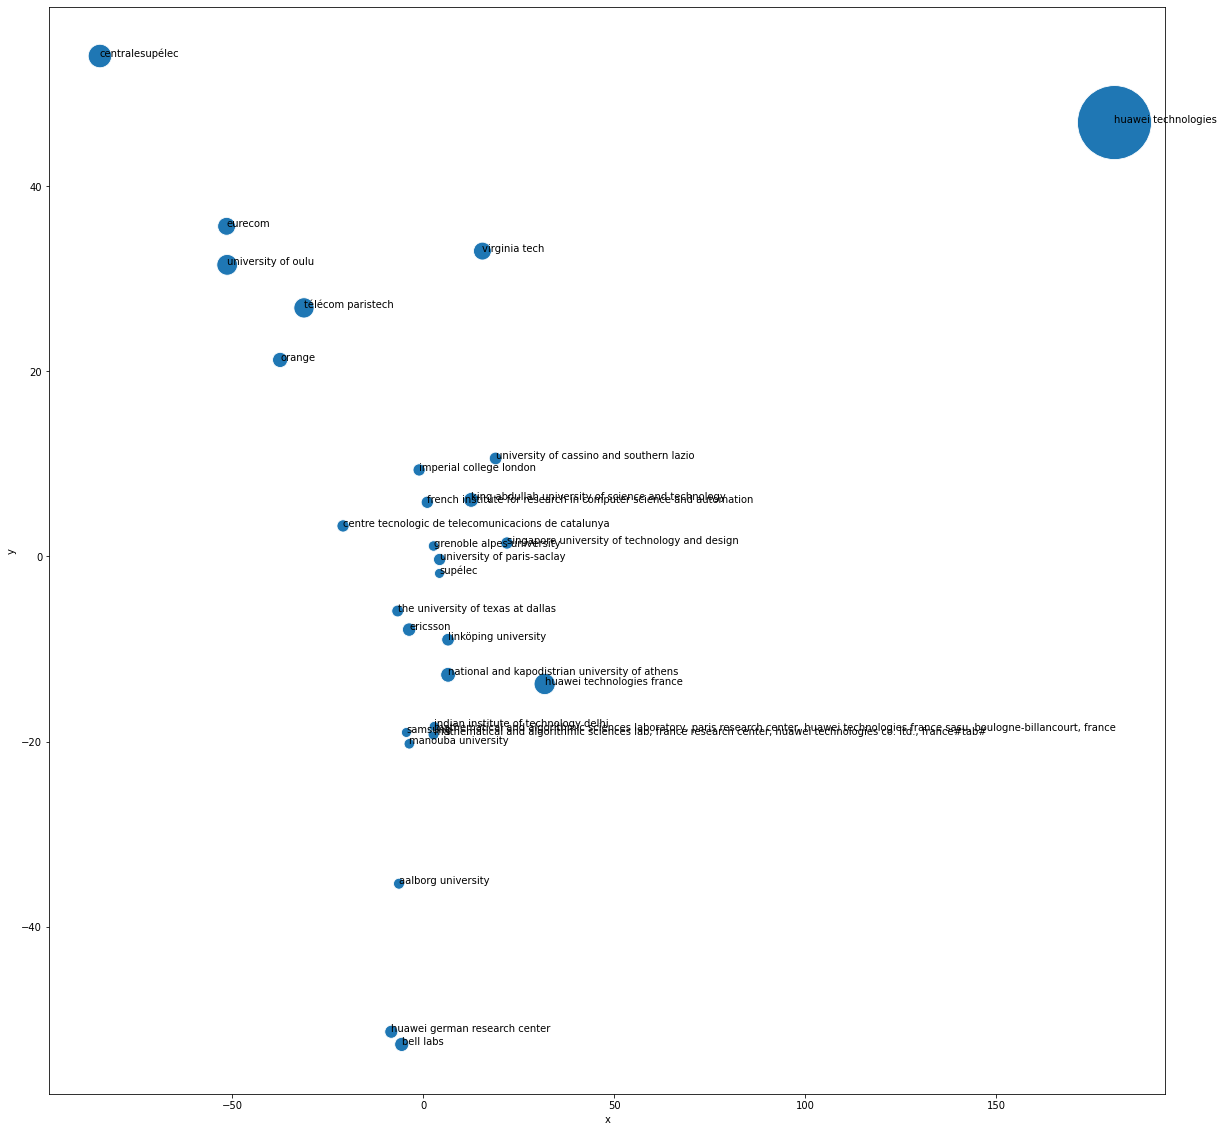

In [507]:
isomap = Isomap(n_components=2)
make_graph(isomap.fit_transform(matrix_data_norm))

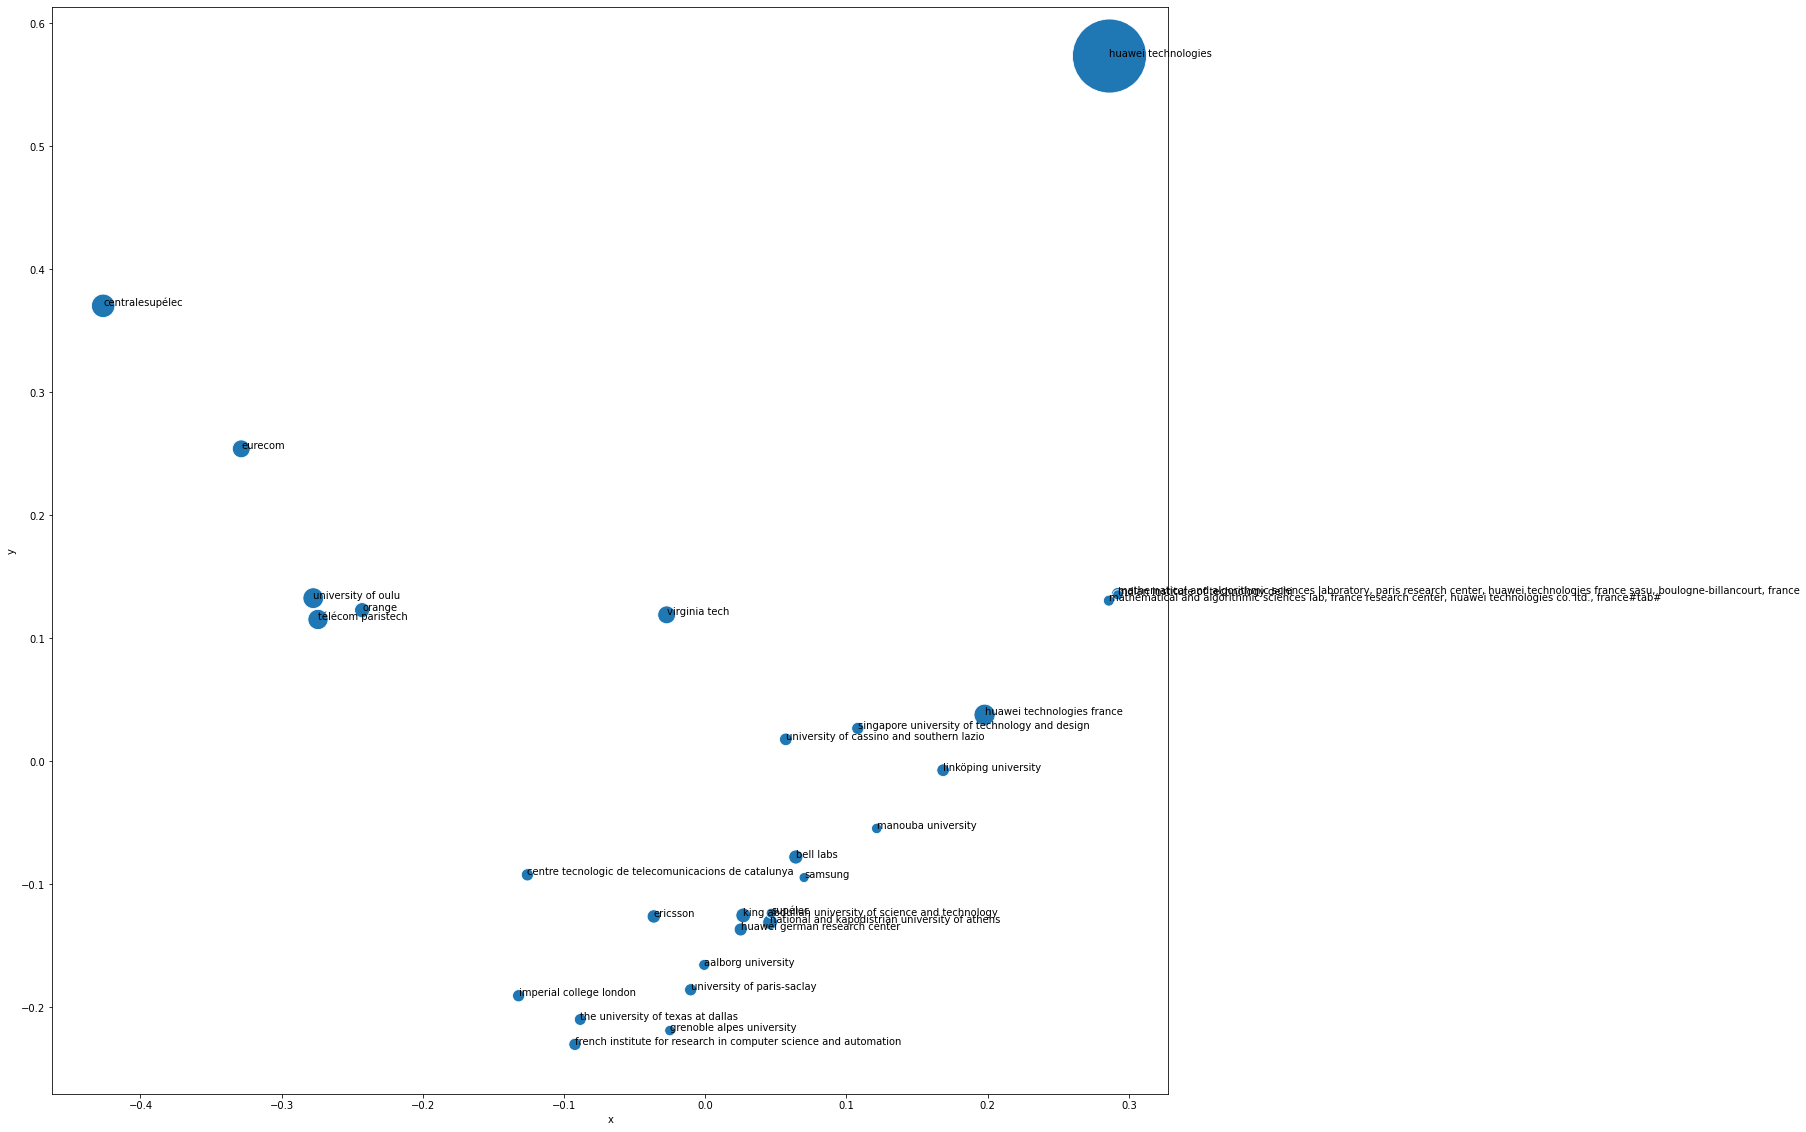

In [508]:
lle = LocallyLinearEmbedding(n_components=2)
make_graph(lle.fit_transform(matrix_data_norm))

/usr/local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


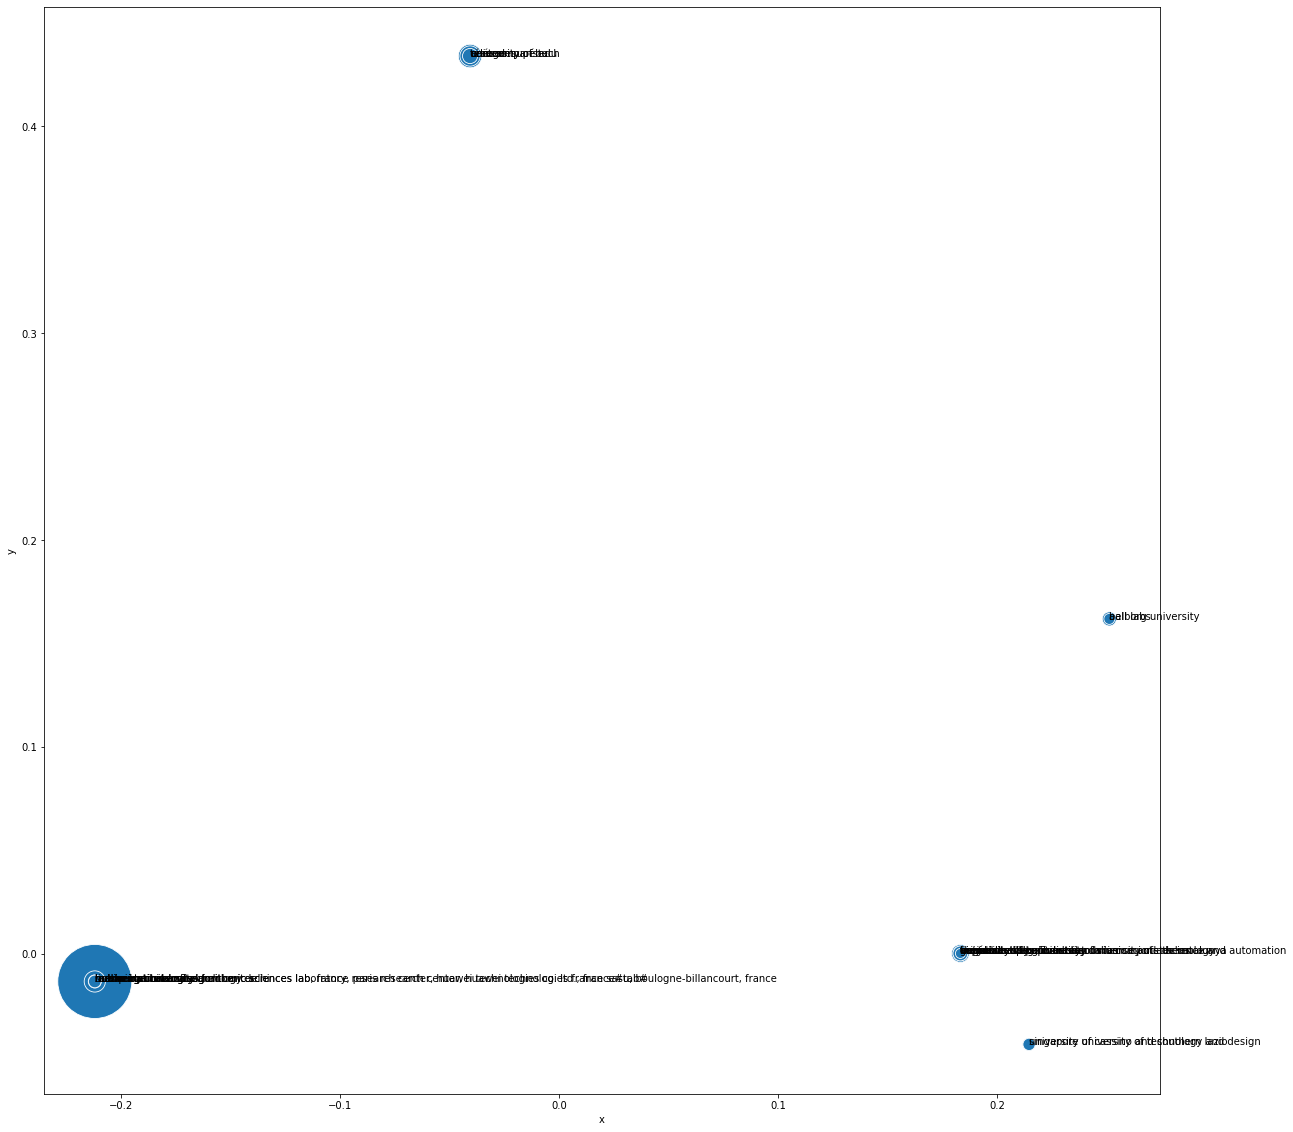

In [509]:
spectral = SpectralEmbedding(n_components=2)
make_graph(spectral.fit_transform(matrix_data_norm))